In [2]:
import mmh3 #library for Minhashing
import numpy as np
import pandas as pd
#import nltk
#from nltk.tokenize import word_tokenize
import mmh3   # Fast, non-cryptographic hash
#import math
#nltk.download('punkt')

In [3]:
df = pd.read_csv("/Users/sararedaelli/Desktop/AMAZON REVIEWS/Books_rating_cleaned_minhashing.csv")

In [4]:
print(df.shape)
print(df.columns)
df['cleanText'][2]

(2968263, 4)
Index(['Id', 'review/score', 'cleanText', 'lang'], dtype='object')


'if people become the books they read and if the child is father to the man then dr seuss theodor seuss geisel is the most influential author poet and artist of modern times for me a daddy to a large family who learned to read with dr seuss and who has memorized too many of the books via repeated readings to young children prof nels brilliant american icon is a long awaited treat at last a serious treatment of this remarkable genius that is both an engaging read and filled with remarkable insights i especially enjoyed and learned more than i care to admit from prof nels discussions of the disneyfication of seuss which nel links to failings in american copyright law the other sides of dr seuss all of which sides were new to me and the political genesis of his secular morality in the wwii cartoon work he did at pm magazine the chapters on geisels poetry and artwork and the link nel makes between seuss and the historical avant guarde alone make this book a must buy for parents and serious

In [5]:
# -------- Parameters --------
q = 1                   # number of words per shingle (1 = word-level)
num_hashes = 100        # number of hash functions (adjust for accuracy)
max_hash = 2**32 - 1    # 32-bit hash space (balances memory and collisions)
np.random.seed(42)      # reproducibility

# -------- Hash function family --------
# Each hash function: h_i(x) = (a_i * x + b_i) mod max_hash
a = np.random.randint(1, max_hash, size=num_hashes, dtype=np.uint64)
b = np.random.randint(0, max_hash, size=num_hashes, dtype=np.uint64)

def get_word_shingles(text, q=1):
    """Return q-word shingles from pre-cleaned text using simple split."""
    #Ensure the text is always a string
    if not isinstance(text, str):
        text = "" if pd.isna(text) else str(text)
    words = text.split()
    if len(words) < q:
        return {" ".join(words)}  # single shingle if too short
    return {" ".join(words[i:i+q]) for i in range(len(words) - q + 1)}

# -------- Hashing utilities --------
 #Turning the word into numbers using a basic hash function: Uses a hash function (mmh3.hash, MurmurHash3) to convert a string (shingle) into a 32-bit number.
def base_hash(shingle):
    return np.uint32(mmh3.hash(shingle, signed=False))

#Creating the signature
def minhash_signature(shingles):
    #Uses base_hash to create the actual vector that corresponds to each review
    hash_values = np.array([base_hash(s) for s in shingles], dtype=np.uint64)
    #we apply a second set of hash functions (polinomial, defined by us) on hash_values, take the min out of each function and put it in a signature with num_hashes colums.
    sig = np.full(num_hashes, np.inf)
    #Computing the value of the hash gunction for each shingle (the columns h(x))
    for i in range(num_hashes):
        combined = (a[i] * hash_values + b[i]) % max_hash
        sig[i] = combined.min()
    return sig.astype(np.uint32)



In [ ]:
# Create empty lists to store results
signatures = []
ratings = []

# Loop over each row
for idx, row in df.iterrows():
    review_text = row['cleanText']              # column 3
    rating = row['review/score']                   # column 2
    
    shingles = get_word_shingles(review_text, q=q)  # generate shingles
    sig_vector = minhash_signature(shingles)        # compute MinHash signature
    
    signatures.append(sig_vector)
    ratings.append(rating)


# Combine signatures and ratings into a DataFrame - one column has all the signatures (one review per row) and the other column has the rating of that review
result_df = pd.DataFrame({
    'signature': signatures,  # each entry is a NumPy array
    'rating': ratings
})
result_df['signature'] = result_df['signature'].apply(lambda x: x.tolist())
#result_df.to_csv("reviews_minhash_single_column.csv", index=False)

In [6]:
# Take a subset of the dataset
sample_df = df.head(1000).copy()

# Create empty lists to store results
signatures = []
ratings = []

# Loop over the subset
for idx, row in sample_df.iterrows():
    review_text = row['cleanText']
    rating = row['review/score']
    
    shingles = get_word_shingles(review_text, q=q)
    sig_vector = minhash_signature(shingles)
    
    signatures.append(sig_vector)
    ratings.append(rating)

# Combine into a result DataFrame
result_df = pd.DataFrame({
    'signature': signatures,
    'rating': ratings
})

# Convert numpy arrays to lists for saving/serialization
result_df['signature'] = result_df['signature'].apply(lambda x: x.tolist())

# Optional: Save for inspection
# result_df.to_csv("reviews_minhash_sample.csv", index=False)


In [9]:
print(result_df.head(1))


                                           signature  rating
0  [10670652, 80136027, 171898098, 37027425, 1563...     4.0


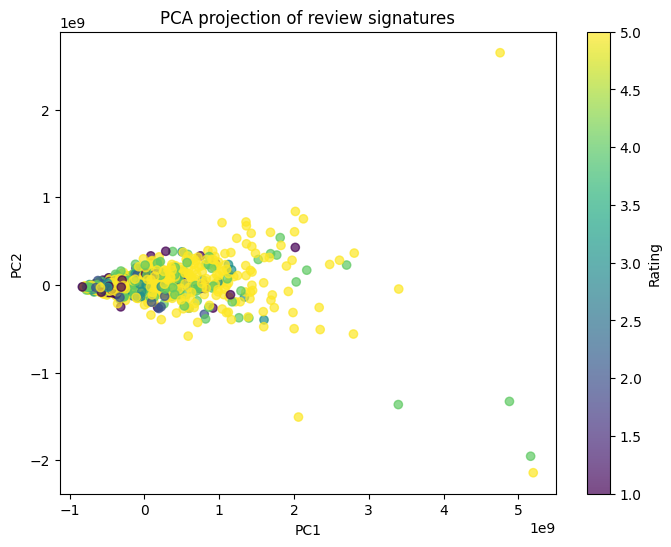

In [10]:
# Convert list of lists into 2D array
X = np.vstack(result_df['signature'].values)
y = result_df['rating'].values  # for coloring points
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2, random_state=42)
reduced = pca.fit_transform(X)

plt.figure(figsize=(8,6))
sc = plt.scatter(reduced[:,0], reduced[:,1], c=y, cmap='viridis', alpha=0.7)
plt.colorbar(sc, label='Rating')
plt.title('PCA projection of review signatures')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()